## Question 1:
Is there a statistical difference in the odds of winning a game when a team is playing in front of their home crowd?

## Hypothesis:
**Null Hypothesis** H<sub>0</sub> = There is *no statistical difference* in the odds of winning a game when a team is playing in front of their home crowd 

**Alternative Hypothesis** H<sub>a</sub> = There is *always* a difference in the odds of winning a game when a team is playing in front of their home crowd.

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
database_name = 'football_db'

In [3]:
conn = psycopg2.connect(f'dbname={database_name}')

In [4]:
cur = conn.cursor()

In [5]:
columns = ['id', 'home_goal', 'away_goal', 'result']

query = f"""
SELECT match_api_id, home_team_goal, away_team_goal, 
CASE WHEN home_team_goal > away_team_goal THEN 'Win' 
     WHEN home_team_goal < away_team_goal THEN 'Lose'
     ELSE 'Draw' 
     END AS result
FROM match
"""

cur.execute(query)
data = cur.fetchall()

In [6]:
df = pd.DataFrame(data, columns=columns)

In [7]:
df.head()

,id,home_goal,away_goal,result
0,492473,1,1,Draw
1,492474,0,0,Draw
2,492475,0,3,Lose
3,492476,5,0,Win
4,492477,1,3,Lose


In [8]:
total_wins = len(df[df['result'] == 'Win'])
total_wins

11917

In [9]:
total_games = len(df['result'])
total_games

25979

In [274]:
# set the (μ) value
mu = total_wins / total_games

In [275]:
sample_size = 100
number_of_games = 1000
samples = np.zeros(sample_size)
for i in range(sample_size):
    """Taking a sample size of the win rate for home games"""
    games = df.iloc[np.random.randint(low=0, high=len(df), size=number_of_games), :]
    win_rate = len(games[games['result'] == 'Win']) / number_of_games
    
    samples[i] = win_rate


In [276]:
samples

array([0.475, 0.429, 0.447, 0.461, 0.45 , 0.458, 0.462, 0.461, 0.486,
       0.44 , 0.458, 0.444, 0.466, 0.454, 0.465, 0.468, 0.457, 0.448,
       0.449, 0.455, 0.452, 0.48 , 0.457, 0.464, 0.443, 0.455, 0.453,
       0.458, 0.475, 0.445, 0.429, 0.476, 0.46 , 0.447, 0.463, 0.445,
       0.456, 0.437, 0.477, 0.444, 0.468, 0.462, 0.473, 0.45 , 0.476,
       0.428, 0.458, 0.458, 0.454, 0.469, 0.459, 0.452, 0.475, 0.468,
       0.44 , 0.445, 0.463, 0.475, 0.465, 0.48 , 0.462, 0.498, 0.47 ,
       0.458, 0.464, 0.429, 0.458, 0.466, 0.456, 0.464, 0.441, 0.433,
       0.459, 0.465, 0.469, 0.461, 0.468, 0.464, 0.46 , 0.472, 0.449,
       0.478, 0.475, 0.459, 0.459, 0.459, 0.468, 0.451, 0.426, 0.463,
       0.438, 0.445, 0.456, 0.467, 0.467, 0.47 , 0.472, 0.481, 0.45 ,
       0.447])

In [277]:
sample_mean = samples.mean()
sample_mean

0.4586400000000001

In [278]:
std = np.std(samples, ddof=1)
std

0.013579187878306396

In [279]:
# T-Test to compare the average mean to the population mean
t = (sample_mean - mu) / (std / np.sqrt(sample_size))
t

-0.05645091673282209

In [280]:
# Degrees of Freedom
df_value = sample_size - 1

### Calculating Critical T-Value
If the test statistic is more extreme than the critical value, then the null hypothesis is rejected in favor of the alternative hypothesis. If the test statistic is not as extreme as the critical value, then the null hypothesis is not rejected.

In [281]:
t_crit = np.round(stats.t.ppf(1 - 0.05, df_value), 3)
t_crit

1.66

In [282]:
results = stats.ttest_1samp(a=samples, popmean=mu)
print(results)
print('\n')

if (results[0]>t_crit) and (results[1]<0.05):
    print ("Null hypothesis rejected. Results are statistically significant with t-value =", 
           round(results[0], 2), "and p-value =", np.round((results[1]), 4))
else:
    print ("Null hypothesis is Accepted")

Ttest_1sampResult(statistic=-0.056450916732822085, pvalue=0.955096371438904)


Null hypothesis is Accepted


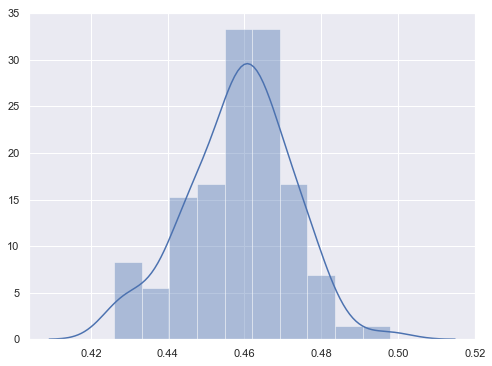

In [283]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8,6)})
sns.distplot(samples)

## Result:
While limiting alpha to 0.05, The P-value is > 0.05. This concludes that there is a statistical difference when a team wins in front of a home crowd therefore accepting the null hypothesis.

---

## Question 2:
Is there a statistical difference in the odds of winning a game when the height of a team is taller than the other team?

## Hypothesis:
**Null Hypothesis** H<sub>0</sub> = There is *no statistical difference* in the odds of winning a game dependent on a teams height.

**Alternative Hypothesis** H<sub>a</sub> = There is *always* a difference in the odds of winning a game dependent on a teams height.

In [20]:
conn = psycopg2.connect('dbname=football_db')

In [21]:
cur = conn.cursor()

In [22]:
columns = ['game_date', 'home_height', 'away_height', 'result' ]

query = f"""
select m.date,  
(H1.height + H2.height + H3.height + H4.height + H5.height + H6.height +
H7.height + H8.height + H9.height + H10.height + H11.height) / 11 H_HEIGHT,
(A1.height + A2.height + A3.height + A4.height + A5.height +  A6.height + 
A7.height + A8.height + A9.height + A10.height + A11.height) / 11 A_HEIGHT,
CASE WHEN home_team_goal > away_team_goal THEN 'Win' 
     WHEN home_team_goal = away_team_goal THEN 'Draw'
     ELSE 'Lose' END as result
FROM Match M
JOIN Player H1 ON M.home_player_1 = H1.player_api_id
JOIN Player H2 ON M.home_player_2 = H2.player_api_id
JOIN Player H3 ON M.home_player_3 = H3.player_api_id
JOIN Player H4 ON M.home_player_4 = H4.player_api_id
JOIN Player H5 ON M.home_player_5 = H5.player_api_id
JOIN Player H6 ON M.home_player_6 = H6.player_api_id
JOIN Player H7 ON M.home_player_7 = H7.player_api_id
JOIN Player H8 ON M.home_player_8 = H8.player_api_id
JOIN Player H9 ON M.home_player_9 = H9.player_api_id
JOIN Player H10 ON M.home_player_10 = H10.player_api_id
JOIN Player H11 ON M.home_player_11 = H11.player_api_id
JOIN Player A1 ON M.away_player_1 = A1.player_api_id
JOIN Player A2 ON M.away_player_2 = A2.player_api_id
JOIN Player A3 ON M.away_player_3 = A3.player_api_id
JOIN Player A4 ON M.away_player_4 = A4.player_api_id
JOIN Player A5 ON M.away_player_5 = A5.player_api_id
JOIN Player A6 ON M.away_player_6 = A6.player_api_id
JOIN Player A7 ON M.away_player_7 = A7.player_api_id
JOIN Player A8 ON M.away_player_8 = A8.player_api_id
JOIN Player A9 ON M.away_player_9 = A9.player_api_id
JOIN Player A10 ON M.away_player_10 = A10.player_api_id
JOIN Player A11 ON M.away_player_11 = A11.player_api_id
"""

cur.execute(query)
data = cur.fetchall()

In [23]:
df = pd.DataFrame(data, columns=columns)

In [24]:
df.head(5)

,game_date,home_height,away_height,result
0,2009-02-27 00:00:00,184.265455,181.263636,Win
1,2009-03-08 00:00:00,181.032727,184.265455,Lose
2,2009-03-07 00:00:00,184.265455,181.032727,Win
3,2009-03-13 00:00:00,184.265455,183.803636,Win
4,2009-03-14 00:00:00,179.878182,181.494545,Draw


In [25]:
win_df = df[df['result']=='Win']

In [26]:
number_of_games = 1500
sample_df = win_df.iloc[np.random.randint(low=0, high=len(win_df), size=number_of_games), :]

In [27]:
experimental = np.array(sample_df['home_height'])
control = np.array(sample_df['away_height'])

In [28]:
mean_home_height = sample_df['home_height'].mean()
mean_home_height

182.0885975757577

In [29]:
mean_away_height = sample_df['away_height'].mean()
mean_away_height

182.123695757576

In [30]:
mean_home_height - mean_away_height

-0.035098181818312923

In [31]:
def variance(sample):
    """return the variance of sample list"""
    sample_mean = np.mean(sample)
    return sum([(i - sample_mean) ** 2 for i in sample])

In [32]:
def sample_variance(sample1, sample2):
    """return the variance between two sample"""
    n_1, n_2 = len(sample1), len(sample2)
    var_1, var_2 = variance(sample1), variance(sample2)
    return (var_1 + var_2)/((n_1 + n_2)-2)


In [33]:
def twosample_tstatistic(expr, ctrl):
    """return the t-statistic value between expr, ctrl"""
    exp_mean, ctrl_mean = np.mean(expr), np.mean(ctrl)
    samp_var = sample_variance(expr, ctrl)
    n_e, n_c = len(expr), len(ctrl)
    num = exp_mean - ctrl_mean
    denom = np.sqrt(samp_var * ((1/n_e)+(1/n_c)))
    return num / denom

In [34]:
t_stat = twosample_tstatistic(experimental, control)
t_stat

-0.5169868251479138

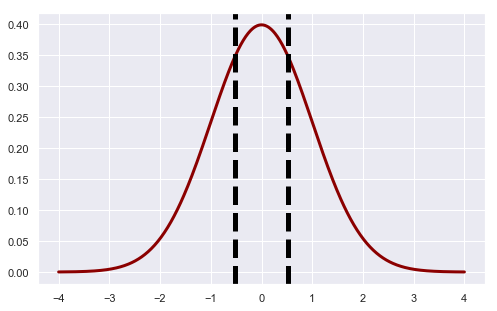

In [35]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(control)
n_experimental = len(experimental)
visualize_t(t_stat, n_control, n_experimental)


In [36]:
stats.t.sf(abs(t_stat), len(experimental)+len(control)-1) * 2

0.6052034793630547

In [37]:
stats.ttest_ind(experimental, control)

Ttest_indResult(statistic=-0.5169868251479134, pvalue=0.6052034920787119)

## Result:
While limiting alpha to 0.05, The P-value is > 0.05. This concludes that there is no statistical difference when a team wins based on the height of teams players, therefore accepting the null hypothesis.

---

## Question 3:
Is there a statistical difference in the odds of losing a game when the defense pressure of a team is higher than the other team?

## Hypothesis:
**Null Hypothesis** H<sub>0</sub> = There is *no statistical difference* in the odds of losing a game dependent on a teams defense pressure.

**Alternative Hypothesis** H<sub>a</sub> = There is *always* a difference in the odds of losing a game dependent on a teams defense pressure.

In [215]:
conn = psycopg2.connect('dbname=football_db')
cur = conn.cursor()

query = f"""
SELECT M.date,  
CASE WHEN home_team_goal > away_team_goal THEN 'Win' 
     WHEN home_team_goal = away_team_goal THEN 'Draw'
     ELSE 'Lose' END AS result,
T.*,
TT.*
FROM Match M
JOIN Team_Attributes AS T ON M.home_team_api_id = T.team_api_id 
AND SUBSTRING(M.season, 1, 4) = SUBSTRING(T.date, 1, 4)
JOIN Team_Attributes AS TT ON M.away_team_api_id = TT.team_api_id
AND SUBSTRING(M.season, 1, 4) = SUBSTRING(TT.date, 1, 4)

"""
cur.execute(query)
data = cur.fetchall()

In [216]:
df = pd.DataFrame(data)

In [217]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,2010-07-31 00:00:00,Win,654,100081,8571,2010-02-22 00:00:00,50,Balanced,NaN,Little,...,45,Normal,Organised,60,Medium,70,Double,70,Wide,Cover
1,2010-07-31 00:00:00,Win,660,110724,8203,2010-02-22 00:00:00,65,Balanced,NaN,Little,...,50,Normal,Organised,65,Medium,65,Press,70,Wide,Cover
2,2010-07-31 00:00:00,Lose,1391,681,10001,2010-02-22 00:00:00,45,Balanced,NaN,Little,...,60,Normal,Organised,45,Medium,50,Press,40,Normal,Cover
3,2010-07-30 00:00:00,Draw,1237,232,9985,2010-02-22 00:00:00,53,Balanced,NaN,Little,...,50,Normal,Organised,70,High,60,Press,70,Wide,Cover
4,2010-08-01 00:00:00,Draw,295,1750,9984,2010-02-22 00:00:00,45,Balanced,NaN,Little,...,60,Normal,Organised,70,High,70,Double,70,Wide,Cover


In [218]:
df = df.drop(range(2,20), axis=1)
df = df.drop(range(21, 27), axis=1)

In [219]:
df = df.drop(range(27, 45), axis=1)
df = df.drop(range(46, 52), axis=1)

In [220]:
df.head()

,0,1,20,45
0,2010-07-31 00:00:00,Win,60,60
1,2010-07-31 00:00:00,Win,60,65
2,2010-07-31 00:00:00,Lose,70,45
3,2010-07-30 00:00:00,Draw,70,70
4,2010-08-01 00:00:00,Draw,65,70


In [221]:
df.columns = ['date',  'result', 'Home_DP', 'Away_DP']
df.head()

,date,result,Home_DP,Away_DP
0,2010-07-31 00:00:00,Win,60,60
1,2010-07-31 00:00:00,Win,60,65
2,2010-07-31 00:00:00,Lose,70,45
3,2010-07-30 00:00:00,Draw,70,70
4,2010-08-01 00:00:00,Draw,65,70


In [222]:
lose_df = df[df['result'] == 'Lose']

In [223]:
len(lose_df)

5041

In [254]:
number_of_games = 500
sample_df = lose_df.iloc[np.random.randint(low=0, 
                                           high=len(lose_df), 
                                           size=number_of_games), :]

In [255]:
experimental = np.array(sample_df['Home_DP'])
control = np.array(sample_df['Away_DP'])

In [256]:
mean_home_dp = experimental.mean()
mean_home_dp

45.142

In [257]:
mean_away_dp = control.mean()
mean_away_dp

47.982

In [258]:
mean_home_dp - mean_away_dp

-2.8399999999999963

In [259]:
t_stat = twosample_tstatistic(experimental, control)
t_stat

-4.185569392946621

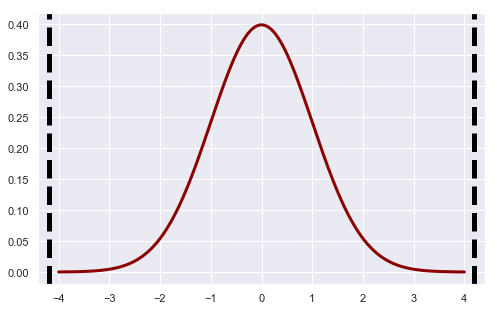

In [260]:
n_control = len(control)
n_experimental = len(experimental)
visualize_t(t_stat, n_control, n_experimental)

In [261]:
stats.t.sf(abs(t_stat), len(experimental)+len(control)-1) * 2

3.0951493685161764e-05

In [262]:
stats.ttest_ind(experimental, control)

Ttest_indResult(statistic=-4.1855693929466256, pvalue=3.095408312294048e-05)

## Result:
While limiting alpha to 0.05, The P-value is < 0.05. This concludes that there is a statistical difference when a team loses based on the teams' defense pressure, therefore rejecting the null hypothesis.

---

## Question 4:
Is there a statistical difference in the odds of winning a game when the offensive attributes(passing & shooting) of a team is higher than the other team?

## Hypothesis:
**Null Hypothesis** H<sub>0</sub> = There is *no statistical difference* in the odds of winning a game dependent on a teams offensive attributes.

**Alternative Hypothesis** H<sub>a</sub> = There is *always* a difference in the odds of winning a game dependent on a teams offensive attributes.

In [194]:
conn = psycopg2.connect('dbname=football')
cur = conn.cursor()

query = f"""
SELECT M.date,  
CASE WHEN home_team_goal > away_team_goal THEN 'Win' 
     WHEN home_team_goal = away_team_goal THEN 'Draw'
     ELSE 'Lose' END AS result,
T.buildupplaypassing + T.chancecreationshooting AS Home_Offense,
TT.buildupplaypassing + TT.chancecreationshooting AS Away_Offense
FROM Match M
JOIN Team_Attributes AS T ON M.home_team_api_id = T.team_api_id 
AND SUBSTRING(M.season, 1, 4) = SUBSTRING(T.date, 1, 4)
JOIN Team_Attributes AS TT ON M.away_team_api_id = TT.team_api_id
AND SUBSTRING(M.season, 1, 4) = SUBSTRING(TT.date, 1, 4)
"""

cur.execute(query)
data = cur.fetchall()

In [195]:
df = pd.DataFrame(data)
df.columns = ['date',  'result', 'Home_Offense', 'Away_Offense']
df.head()

,date,result,Home_Offense,Away_Offense
0,2010-07-31 00:00:00,Win,110,85
1,2010-07-31 00:00:00,Win,110,110
2,2010-07-31 00:00:00,Lose,115,125
3,2010-07-30 00:00:00,Draw,105,110
4,2010-08-01 00:00:00,Draw,90,110


In [196]:
win_df = df[df['result'] == 'Win']

In [206]:
number_of_games = 2000
sample_df = win_df.iloc[np.random.randint(low=0, 
                                           high=len(win_df), 
                                           size=number_of_games), :]

In [207]:
experimental = np.array(sample_df['Home_Offense'])
control = np.array(sample_df['Away_Offense'])

In [208]:
mean_home_offence = experimental.mean()
mean_home_offence

101.819

In [209]:
mean_away_offence = control.mean()
mean_away_offence

102.4625

In [210]:
mean_home_offence - mean_away_offence

-0.6435000000000031

In [211]:
t_stat = twosample_tstatistic(experimental, control)
t_stat

-1.3842968942852623

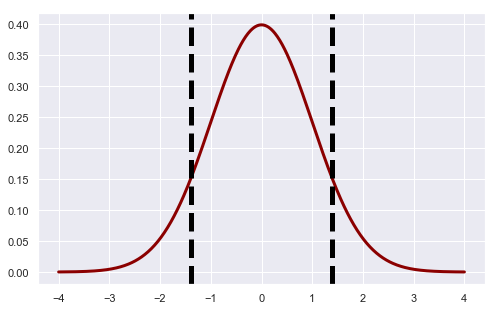

In [212]:
n_control = len(control)
n_experimental = len(experimental)
visualize_t(t_stat, n_control, n_experimental)

In [213]:
stats.t.sf(abs(t_stat), len(experimental)+len(control)-1) * 2

0.16634480522907188

In [214]:
stats.ttest_ind(experimental, control)

Ttest_indResult(statistic=-1.3842968942852578, pvalue=0.16634482454769994)

## Result:
While limiting alpha to 0.05, The P-value is > 0.05. This concludes that there is no statistical difference when a team wins based on the teams' offensive attributes(passing & shooting), therefore accepting the null hypothesis.

---

## Question 5:
Is there a statistical difference in the odds of winning a game when a team is playing in front of their home crowd vs away crowd?

## Hypothesis:
**Null Hypothesis** H<sub>0</sub> = There is *no statistical difference* in the odds of winning a game when a team is playing in front of their home crowd  

**Alternative Hypothesis** H<sub>a</sub> = There is *always* a difference in the odds of winning a game when a team is playing in front of their home crowd or away crowd?.

In [284]:
cur = conn.cursor()

query = f"""
SELECT M.date,  
CASE WHEN home_team_goal > away_team_goal THEN 'Win' 
     WHEN home_team_goal = away_team_goal THEN 'Draw'
     ELSE 'Lose' END AS result
FROM Match M
"""
cur.execute(query)
data = cur.fetchall()

In [285]:
df = pd.DataFrame(data, columns=['date', 'result'])
df.head()

,date,result
0,2008-08-17 00:00:00,Draw
1,2008-08-16 00:00:00,Draw
2,2008-08-16 00:00:00,Lose
3,2008-08-17 00:00:00,Win
4,2008-08-16 00:00:00,Lose


In [286]:
h_win_df = df[df['result'] == "Win"]
a_win_df = df[df['result'] == 'Lose']

In [287]:
total_games = len(df)
home_wins = len(h_win_df)
away_wins = len(a_win_df)

In [288]:
#H0: odds of winning at home is same with odds of winning at away is same
#H1: odds of winning at home is higher than odds of winning at away
#P(H) = P(A)
## mu = home_wins / total_games - away_wins / total_games
mu = 0

In [289]:
sample_size = 30
number_of_games = 500
samples = np.zeros(sample_size)
for i in range(sample_size):
    games = df.iloc[np.random.randint(low=0, high=len(df), size=number_of_games), :]
    h_win_rate = len(games[games['result'] == 'Win']) / number_of_games
    a_win_rate = len(games[games['result'] == 'Lose']) / number_of_games
    samples[i] = h_win_rate - a_win_rate
    

In [290]:
sample_mean = samples.mean()
sample_mean

0.17439999999999994

In [291]:
std = np.std(samples, ddof=1)
std

0.04468556814006061

In [292]:
t = (sample_mean - mu) / (std / np.sqrt(sample_size))
t

21.376658730062054

In [293]:
#degree of freedom
df_value = sample_size - 1

In [294]:
t_crit = np.round(stats.t.ppf(1 - 0.05, df_value), 3)
t_crit

1.699

In [295]:
results = stats.ttest_1samp(a=samples, popmean=mu)
print(results)
print('\n')

if (results[0]>t_crit) and (results[1]<0.05):
    print ("Null hypothesis rejected. Results are statistically significant with t-value =", 
           round(results[0], 2), "and p-value =", np.round((results[1]), 4))
else:
    print ("Null hypothesis is Accepted")

Ttest_1sampResult(statistic=21.376658730062054, pvalue=2.6823630461920174e-19)


Null hypothesis rejected. Results are statistically significant with t-value = 21.38 and p-value = 0.0


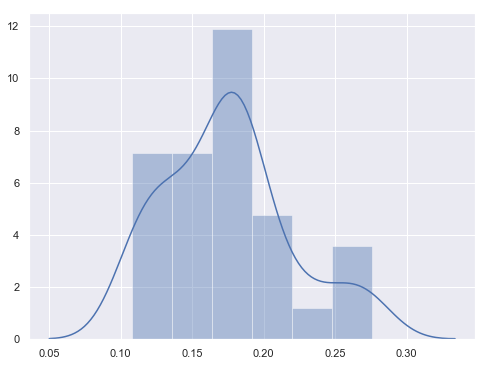

In [296]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8,6)})
sns.distplot(samples);

## Result:
While limiting alpha to 0.05, The P-value is < 0.05. This concludes that there is a statistical difference when a team wins in front of a home crowd or wins at away games, therefore accepting the alternative hypothesis.